In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Modules**

In [ ]:
!pip install Pillow
!pip install Keras-Preprocessing
!pip install ktrain

In [ ]:
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

import seaborn as sns
import plotly.express as px
import pickle
import joblib
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import re
import ktrain
from ktrain import text
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences

sns.set()
%matplotlib inline

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
datafolder='/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Data/'
modelfolder='/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/'
arrayfolder='/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/'

# **Data Preparation for Machine Learning**

### **Help Methods**

###### DataLoad and process ( Methods )

In [ ]:
def DataPreparationforML(filename):
  df_category_model = pd.read_csv(datafolder+filename)
  df_category_model.drop(columns=['Unnamed: 0'],inplace=True)
  #print(filename +' Shape : '+df_category_model.shape)
  df_category_model['CONTENT']=df_category_model['CONTENT'].fillna("")
  df_category_model.isna().sum()
  df_category_model['lower_case'] = df_category_model['CONTENT'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))
  df_category_model['alphabatic'] = df_category_model['lower_case'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x)).apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
  df_category_model['without-link'] = df_category_model['alphabatic'].apply(lambda x: re.sub(r'http\S+', '', x))
  tokenizer = RegexpTokenizer(r'\w+')
  df_category_model['Special_word'] = df_category_model.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)
  stop = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]
  df_category_model['stop_words'] = df_category_model['Special_word'].apply(lambda x: [item for item in x if item not in stop])
  df_category_model['stop_words'] = df_category_model['stop_words'].astype('str')
  df_category_model['short_word'] = df_category_model['stop_words'].str.findall('\w{2,}')
  df_category_model['string']=df_category_model['short_word'].str.join(' ')
  df_category_model['TITLE2'] = df_category_model['string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
  return df_category_model


###### ApplyNgram ( Methods )

In [ ]:
def ApplyNgramAndSave(df_category_model,model):
  x_train, x_test, y_train, y_test = train_test_split(df_category_model["TITLE2"],df_category_model["CATEGORY_CLASS"], test_size = 0.25, random_state = 42)
  count_vect = CountVectorizer(ngram_range=(1, 2), max_features = 10000)
  transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
  x_train_counts = count_vect.fit_transform(x_train)
  x_train_tfidf = transformer.fit_transform(x_train_counts)
  x_test_counts = count_vect.transform(x_test)
  x_test_tfidf = transformer.transform(x_test_counts)
  print (x_train_tfidf.shape,x_test_tfidf.shape, y_train.shape, y_test.shape)
  joblib.dump(x_train_counts, arrayfolder+'x_train_counts_'+model+'.pkl')
  joblib.dump(x_train_tfidf, arrayfolder+'x_train_tfidf_'+model+'.pkl')
  joblib.dump(x_test_counts, arrayfolder+'x_test_counts_'+model+'.pkl')
  joblib.dump(x_test_tfidf, arrayfolder+'x_test_tfidf_'+model+'.pkl')
  joblib.dump(x_train, arrayfolder+'x_train_'+model+'.pkl')
  joblib.dump(x_test, arrayfolder+'x_test_'+model+'.pkl')
  joblib.dump(y_train, arrayfolder+'y_train_'+model+'.pkl')
  joblib.dump(y_test, arrayfolder+'y_test_'+model+'.pkl')
  joblib.dump(count_vect, arrayfolder+'count_vect_'+model+'.pkl')
  joblib.dump(transformer, arrayfolder+'transformer_'+model+'.pkl')

###### Visualization ( Methods )

In [ ]:
def Visualization(df_category_model):
  fig = plt.figure(figsize=(14,7))
  df_category_model['length'] = df_category_model.TITLE2.str.split().apply(len)
  ax1 = fig.add_subplot(122)
  sns.histplot(df_category_model['length'], ax=ax1,color='green')
  describe = df_category_model.length.describe().to_frame().round(2)
  ax2 = fig.add_subplot(121)
  ax2.axis('off')
  font_size = 14
  bbox = [0, 0, 1, 1]
  table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
  table.set_fontsize(font_size)
  fig.suptitle('Distribution of text length for text.', fontweight='bold',fontsize = 25)
  plt.show()

  sns.set_theme(style="whitegrid")
  plt.tick_params(axis = 'y', left = False, right = True, labelleft = False, labelright = True)
  plt.xticks(rotation = 90)
  sns.countplot(x=df_category_model["CATEGORY_CLASS"],facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("BrBG", 2),orient='h')
  plt.title('Count by Class ', fontweight='bold',fontsize = 25)
  plt.show()


In [ ]:
def Visualization2(df_category_model,category_clss):
  text=df_category_model[df_category_model['CATEGORY_CLASS']==category_clss]
  top = Counter([item for sublist in text['short_word'] for item in sublist])
  temp_positive = pd.DataFrame(top.most_common(20))
  temp_positive.columns = ['Common_words','count']
  fig = px.bar(temp_positive, x="count", y="Common_words", title='<b>Most Commmon Words in ( '+category_clss+" ) <b>", orientation='h',
             width=700, height=700,color='Common_words')
  fig.update_layout(
    font=dict(

        size=12,  # Set the font size here
    )
   )
  fig.show()


In [ ]:
def Visualization3(df_category_model,category_clss):
  normal_words =' '.join([text for text in df_category_model['TITLE2'][df_category_model['CATEGORY_CLASS'] == category_clss]])
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.title("WordCloud ( " + category_clss +" )",fontweight='bold',fontsize = 25)
  plt.show()



---

### **MODEL #1**

---



In [ ]:
df_category_emotion_model1=DataPreparationforML('df_category_Emotion_unique1.csv')

In [ ]:
df_category_emotion_model1.shape

(296203, 10)

In [ ]:
df_category_emotion_model1.head()

,CONTENT,CATEGORY_CLASS,lower_case,alphabatic,without-link,Special_word,stop_words,short_word,string,TITLE2
0,i dont like that it makes mike mad because i f...,ANGER,i dont like that it makes mike mad because i f...,i dont like that it makes mike mad because i f...,i dont like that it makes mike mad because i f...,"[i, dont, like, that, it, makes, mike, mad, be...","['dont', 'like', 'makes', 'mike', 'mad', 'feel...","[dont, like, makes, mike, mad, feel, though, s...",dont like makes mike mad feel though supposed ...,dont like make mike mad feel though supposed s...
1,im still unstable but im feeling very sarcasti...,ANGER,im still unstable but im feeling very sarcasti...,im still unstable but im feeling very sarcasti...,im still unstable but im feeling very sarcasti...,"[im, still, unstable, but, im, feeling, very, ...","['im', 'still', 'unstable', 'im', 'feeling', '...","[im, still, unstable, im, feeling, sarcastic, ...",im still unstable im feeling sarcastic bitter,im still unstable im feeling sarcastic bitter
2,i feel incredibly greedy whenever i take so mu...,ANGER,i feel incredibly greedy whenever i take so mu...,i feel incredibly greedy whenever i take so mu...,i feel incredibly greedy whenever i take so mu...,"[i, feel, incredibly, greedy, whenever, i, tak...","['feel', 'incredibly', 'greedy', 'whenever', '...","[feel, incredibly, greedy, whenever, take, muc...",feel incredibly greedy whenever take much bite...,feel incredibly greedy whenever take much bite...
3,i have been in bitchy mood the more i think th...,ANGER,i have been in bitchy mood the more i think th...,i have been in bitchy mood the more i think th...,i have been in bitchy mood the more i think th...,"[i, have, been, in, bitchy, mood, the, more, i...","['bitchy', 'mood', 'think', 'feel', 'bitchy']","[bitchy, mood, think, feel, bitchy]",bitchy mood think feel bitchy,bitchy mood think feel bitchy
4,i feel angry that the police is not being supp...,ANGER,i feel angry that the police is not being supp...,i feel angry that the police is not being supp...,i feel angry that the police is not being supp...,"[i, feel, angry, that, the, police, is, not, b...","['feel', 'angry', 'police', 'not', 'supportive...","[feel, angry, police, not, supportive, case, m...",feel angry police not supportive case mad expo...,feel angry police not supportive case mad expo...


###### One Time

In [ ]:
train_data = pd.read_csv(datafolder+'df_category_Emotion_unique1.csv')
train_data.drop(columns=['Unnamed: 0'],inplace=True)
train_data_1=train_data[train_data["CATEGORY_CLASS"]=="ANGER"]
train_data_2=train_data[train_data["CATEGORY_CLASS"]=="HAPPY"]
train_data_3=train_data[train_data["CATEGORY_CLASS"]=="LOVE"]
train_data_4=train_data[train_data["CATEGORY_CLASS"]=="NEUTRAL"]
train_data_5=train_data[train_data["CATEGORY_CLASS"]=="SAD"]

train_data_1=train_data_1.sample(n=60000, random_state=42)
train_data_2=train_data_2.sample(n=60000, random_state=42)
#train_data_3=train_data_3.sample(n=60000, random_state=42)
train_data_4=train_data_4.sample(n=60000, random_state=42)
train_data_5=train_data_5.sample(n=60000, random_state=42)

train_data_1.shape,train_data_2.shape,train_data_3.shape,train_data_4.shape,train_data_5.shape

((60000, 2), (60000, 2), (56203, 2), (60000, 2), (60000, 2))

In [ ]:
train_data = pd.concat([train_data_1, train_data_2,train_data_3,train_data_4,train_data_5], axis=0).reset_index()
train_data.drop(columns=['index'],inplace=True)
train_data.shape

(296203, 2)

In [ ]:
train_data.to_csv(datafolder+'df_category_Emotion_unique1.csv')

###### **Visualization Model #1**

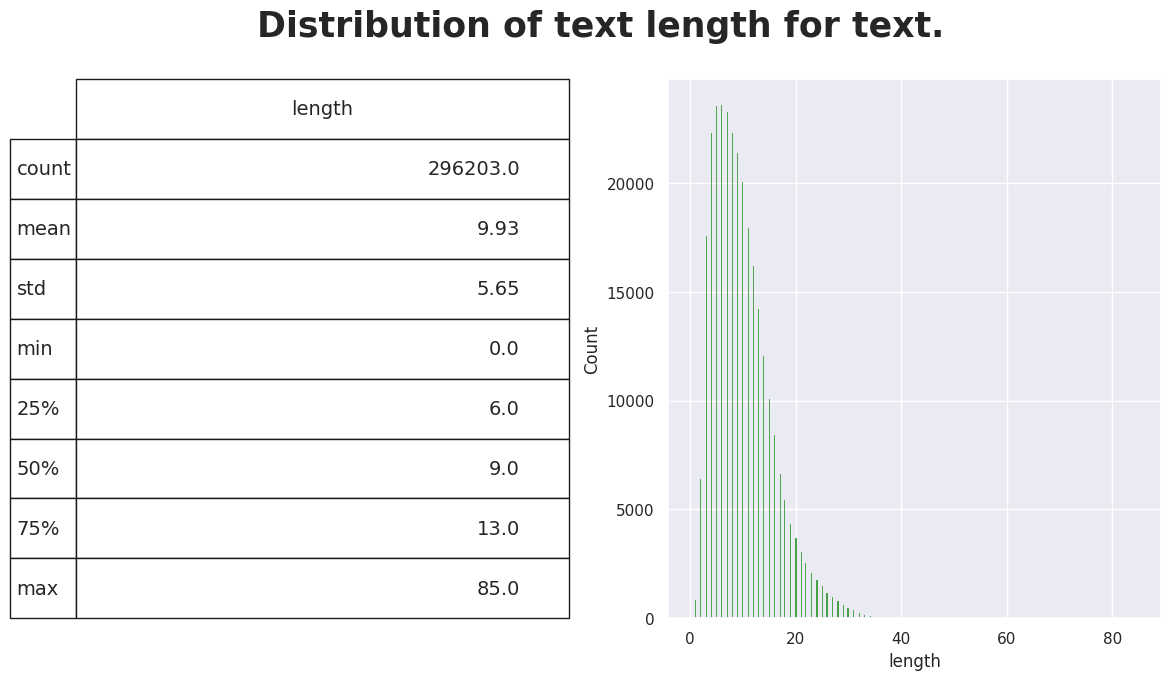

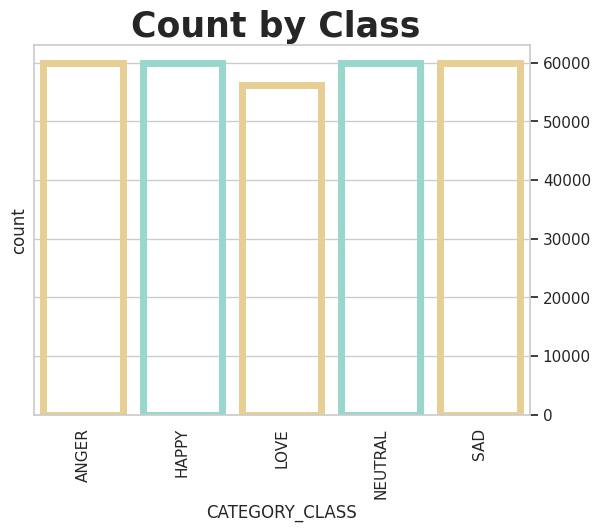

In [ ]:
Visualization(df_category_emotion_model1)

In [ ]:
list(set(df_category_emotion_model1["CATEGORY_CLASS"]))

['NEUTRAL', 'ANGER', 'SAD', 'LOVE', 'HAPPY']

In [ ]:
Category_class1=list(set(df_category_emotion_model1["CATEGORY_CLASS"]))

In [ ]:
for catcls in Category_class1:
  Visualization2(df_category_emotion_model1,catcls)

In [ ]:
for catcls in Category_class1:
  Visualization3(df_category_emotion_model1,catcls)

Output hidden; open in https://colab.research.google.com to view.

###### **Applying N-gram & Save NumPyArrays Model #1**

In [ ]:
ApplyNgramAndSave(df_category_emotion_model1,"emotionmodel1")

(222152, 10000) (74051, 10000) (222152,) (74051,)


# **Data Preparation for Deep Learning**

### **Help Methods**

In [ ]:
vocabulary_size = 1000
max_text_len = 768
stemmer = SnowballStemmer('english')
stop_words = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]

In [ ]:
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [stemmer.stem(word) for word in words if not word in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

In [ ]:
def DataPreparationforDL(filename,model,category_class):
  df_category_model = pd.read_csv(datafolder+filename)
  df_category_model.drop(columns=['Unnamed: 0'],inplace=True)
  df_category_model['CONTENT']=df_category_model['CONTENT'].fillna("")
  df_category_model['cleaned_text'] = df_category_model['CONTENT'].apply(preprocess_text)
  tokenizer = Tokenizer(num_words=vocabulary_size)
  tokenizer.fit_on_texts(df_category_model['cleaned_text'].values)
  le = len(tokenizer.word_index) + 1
  print(le)
  sequences = tokenizer.texts_to_sequences(df_category_model['cleaned_text'].values)
  X_DeepLearning = pad_sequences(sequences, maxlen=max_text_len)
  labl=0
  category_class=list(set(df_category_model['CATEGORY_CLASS']))
  for catcls in category_class:
    df_category_model.loc[df_category_model['CATEGORY_CLASS'] == catcls , 'LABEL'] = labl
    labl=labl+1
  labels = to_categorical(df_category_model['LABEL'], num_classes=labl)
  XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning , labels, test_size=0.25, random_state=42)
  print((XX_train.shape, y_train.shape, XX_test.shape, y_test.shape))
  joblib.dump(XX_train, arrayfolder+'XX_train_'+model+'_d.pkl')
  joblib.dump(XX_test, arrayfolder+'XX_test_'+model+'_d.pkl')
  joblib.dump(y_train, arrayfolder+'yy_train_'+model+'_d.pkl')
  joblib.dump(y_test, arrayfolder+'yy_test_'+model+'_d.pkl')
  joblib.dump(X_DeepLearning, arrayfolder+'X_DeepLearning_'+model+'_d.pkl')
  joblib.dump(sequences, arrayfolder+'sequences_'+model+'_d.pkl')
  joblib.dump(vocabulary_size, arrayfolder+'vocabulary_size_'+model+'_d.pkl')
  joblib.dump(max_text_len, arrayfolder+'max_text_len_'+model+'_d.pkl')
  joblib.dump(tokenizer, arrayfolder+'tokenizer'+model+'_d.pkl')




---

### **MODEL #1**

---

In [ ]:
Category_class1=['NEUTRAL', 'ANGER', 'SAD', 'LOVE', 'HAPPY']
DataPreparationforDL('df_category_Emotion_unique1.csv','emotionmodel2',Category_class1)

63151
((222152, 768), (222152, 5), (74051, 768), (74051, 5))
